In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as PILImage
import cv2 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder # Can be an alternative if folders are structured correctly
from tqdm.notebook import tqdm # For progress bars (optional, install if needed)
import copy # To save best model weights

In [2]:
folder_path_tomato_Target = "/PlantVillage/Tomato__Target_Spot"
folder_path_tomato_mosaic_virus = "/PlantVillage/Tomato__Tomato_mosaic_virus"
folder_path_tomato_Curl_Virus = "/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus"
folder_path_tomato_Bacterial_spot = "/PlantVillage/Tomato_Bacterial_spot"
folder_path_tomato_Early = "/PlantVillage/Tomato_Early_blight"
folder_path_tomato_Late = "/PlantVillage/Tomato_Late_blight"
folder_path_tomato_leaf_mold = "/PlantVillage/Tomato_Leaf_Mold"
folder_path_tomato_Septoria_leaf = "/PlantVillage/Tomato_Septoria_leaf_spot"
folder_path_tomato_Spider_mites = "/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite"
folder_path_tomato_healthy = "/PlantVillage/Tomato_healthy"

image_files_tomato_Target = [os.path.join(folder_path_tomato_Target, file) for file in os.listdir(folder_path_tomato_Target) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
image_files_tomato_mosaic_virus = [os.path.join(folder_path_tomato_mosaic_virus, file) for file in os.listdir(folder_path_tomato_mosaic_virus) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
image_files_tomato_Curl_Virus = [os.path.join(folder_path_tomato_Curl_Virus, file) for file in os.listdir(folder_path_tomato_Curl_Virus) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
image_files_tomato_Bacterial_spot = [os.path.join(folder_path_tomato_Bacterial_spot, file) for file in os.listdir(folder_path_tomato_Bacterial_spot) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
image_files_tomato_Early = [os.path.join(folder_path_tomato_Early, file) for file in os.listdir(folder_path_tomato_Early) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
image_files_tomato_Late = [os.path.join(folder_path_tomato_Late, file) for file in os.listdir(folder_path_tomato_Late) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
image_files_tomato_leaf_mold = [os.path.join(folder_path_tomato_leaf_mold, file) for file in os.listdir(folder_path_tomato_leaf_mold) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
image_files_tomato_Septoria_leaf = [os.path.join(folder_path_tomato_Septoria_leaf, file) for file in os.listdir(folder_path_tomato_Septoria_leaf) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
image_files_tomato_Spider_mites = [os.path.join(folder_path_tomato_Spider_mites, file) for file in os.listdir(folder_path_tomato_Spider_mites) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
image_files_tomato_healthy = [os.path.join(folder_path_tomato_healthy, file) for file in os.listdir(folder_path_tomato_healthy) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]

# Combine all image files into a single list
image_files_tomato = image_files_tomato_Target + image_files_tomato_mosaic_virus + image_files_tomato_Curl_Virus + image_files_tomato_Bacterial_spot + image_files_tomato_Early + image_files_tomato_Late + image_files_tomato_leaf_mold + image_files_tomato_Septoria_leaf + image_files_tomato_Spider_mites + image_files_tomato_healthy

df_tomato = pd.DataFrame(image_files_tomato, columns=["File Path"])

# Combine DataFrames
data_tomato = pd.concat([df_tomato], ignore_index=True)

# Add labels
label_map_tomato = {
    'Tomato__Target_Spot': 0,
    'Tomato__Tomato_mosaic_virus': 1,
    'Tomato__Tomato_YellowLeaf__Curl_Virus': 2,
    'Tomato_Bacterial_spot': 3,
    'Tomato_Early_blight': 4,
    'Tomato_Late_blight': 5,
    'Tomato_Leaf_Mold': 6,
    'Tomato_Septoria_leaf_spot': 7,
    'Tomato_Spider_mites_Two_spotted_spider_mite': 8,
    'Tomato_healthy': 9
}
data_tomato['Label_Str'] = data_tomato['File Path'].apply(lambda x: x.split('/')[-2])
data_tomato['Label'] = data_tomato['Label_Str'].map(label_map_tomato)
data_tomato['Label'] = data_tomato['Label'].astype(int)
data_tomato['File Path'] = data_tomato['File Path'].astype(str)

# Shuffle the data
data = data_tomato.sample(frac=1, random_state=42).reset_index(drop=True)

In [3]:
print("Combined DataFrame Head:")
print(data.head())
print("\nDataFrame Info:")
print(data.info())
print("\nValue Counts for Labels:")
print(data['Label_Str'].value_counts())

Combined DataFrame Head:
                                           File Path  \
0  /Pla...   
1  /Pla...   
2  /Pla...   
3  /Pla...   
4  /Pla...   

                                     Label_Str  Label  
0  Tomato_Spider_mites_Two_spotted_spider_mite      8  
1                        Tomato_Bacterial_spot      3  
2                           Tomato_Late_blight      5  
3                               Tomato_healthy      9  
4                    Tomato_Septoria_leaf_spot      7  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15615 entries, 0 to 15614
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File Path  15615 non-null  object
 1   Label_Str  15615 non-null  object
 2   Label      15615 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 366.1+ KB
None

Value Counts for Labels:
Label_Str
Tomato__Tomato_YellowLeaf__Curl_Virus          3208
Tomato_Bacterial_spot                          


Image Dimension Statistics:
        Height    Width  Channels
count  15615.0  15615.0   15615.0
mean     256.0    256.0       3.0
std        0.0      0.0       0.0
min      256.0    256.0       3.0
25%      256.0    256.0       3.0
50%      256.0    256.0       3.0
75%      256.0    256.0       3.0
max      256.0    256.0       3.0

Unique Image Dimensions (Height, Width): [[256 256]]

All images have the same dimensions.

Unique Channel Counts:
Channels
3    15615
Name: count, dtype: int64


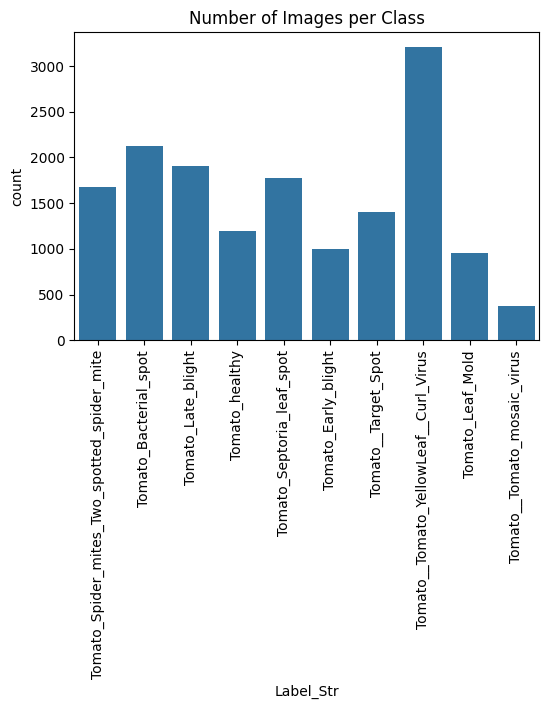

Label_Str
Tomato__Tomato_YellowLeaf__Curl_Virus          3208
Tomato_Bacterial_spot                          2127
Tomato_Late_blight                             1909
Tomato_Septoria_leaf_spot                      1771
Tomato_Spider_mites_Two_spotted_spider_mite    1676
Tomato__Target_Spot                            1404
Tomato_healthy                                 1195
Tomato_Early_blight                            1000
Tomato_Leaf_Mold                                952
Tomato__Tomato_mosaic_virus                     373
Name: count, dtype: int64


In [4]:
image_dims = []
error_files = []
for file_path in data['File Path']:
    try:
        img = cv2.imread(file_path)
        if img is not None:
            image_dims.append(img.shape)
        else:
            print(f"Warning: Could not read image {file_path} with OpenCV. Skipping.")
            error_files.append(file_path)
    except Exception as e:
        print(f"Error reading image {file_path}: {e}")
        error_files.append(file_path)

if error_files:
    print(f"\nRemoving {len(error_files)} files that could not be read.")
    data = data[~data['File Path'].isin(error_files)].reset_index(drop=True)

dims_df = pd.DataFrame(image_dims, columns=['Height', 'Width', 'Channels'])
print("\nImage Dimension Statistics:")
print(dims_df.describe())
unique_dims = dims_df[['Height', 'Width']].drop_duplicates().values
print("\nUnique Image Dimensions (Height, Width):", unique_dims)
if len(unique_dims) > 1:
    print("\nWarning: Images have varying dimensions. Resizing will be necessary.")
else:
    print("\nAll images have the same dimensions.")
print("\nUnique Channel Counts:")
print(dims_df['Channels'].value_counts())
if (dims_df['Channels'] != 3).any():
     print("Warning: Not all images are 3-channel (RGB). Check/convert non-RGB images.")

plt.figure(figsize=(6, 4))
sns.countplot(x='Label_Str', data=data)
plt.title('Number of Images per Class')
plt.xticks(rotation=90)
plt.show()
print(data['Label_Str'].value_counts())

In [5]:
train_df, temp_df = train_test_split(
    data, test_size=0.30, random_state=42, stratify=data['Label'])

val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42, stratify=temp_df['Label'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 10930
Validation samples: 2342
Test samples: 2343


In [6]:
class PlantDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with 'File Path' and 'Label' columns.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.dataframe.iloc[idx]['File Path']
        try:
            # Use PIL for compatibility with torchvision transforms
            image = PILImage.open(img_path).convert('RGB') # Ensure 3 channels
        except Exception as e:
            print(f"Error loading image {img_path}: {e}. Returning None.")
            image = PILImage.open(img_path).convert('RGB')


        label = self.dataframe.iloc[idx]['Label']
        label = torch.tensor(label, dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)

        return image, label 

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
PATIENCE = 5 

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [9]:
train_dataset = PlantDataset(train_df, transform=train_transform)
val_dataset = PlantDataset(val_df, transform=val_test_transform)
test_dataset = PlantDataset(test_df, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [10]:
class SimpleCNN(nn.Module):
    # Added num_classes parameter for clarity, assuming it will be passed during instantiation
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # --- Convolutional Blocks ---
        # Block 1: 256x256 -> 128x128
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # Input channels = 3 (RGB)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Block 2: 128x128 -> 64x64
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Block 3: 64x64 -> 32x32
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Block 4 (New): 32x32 -> 16x16
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # --- Calculate Flattened Size ---
        # After 4 pooling layers (stride 2), the height/width are divided by 2^4 = 16
        # Input: 256x256
        # After pool1: 128x128
        # After pool2: 64x64
        # After pool3: 32x32
        # After pool4: 16x16
        # The number of channels after conv_block4 is 256.
        # So, the flattened size is channels * height * width
        flattened_height = IMG_HEIGHT // 16
        flattened_width = IMG_WIDTH // 16
        num_output_features_conv = 256 # Channels from last conv layer
        flattened_size = num_output_features_conv * flattened_height * flattened_width
        # flattened_size = 256 * (256 // 16) * (256 // 16) = 256 * 16 * 16 = 65536

        # --- Fully Connected Block ---
        self.fc_block = nn.Sequential(
            # ----> ADD FLATTEN HERE <----
            nn.Flatten(),  # Flattens the output of conv_block4
            # Input features must match flattened_size
            nn.Linear(flattened_size, 512), # Increased dense layer size
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes) # Output layer
        )

    def forward(self, x):
        # Pass through convolutional blocks
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)

        # ---> The nn.Flatten() is now inside self.fc_block <---
        # Pass through fully connected block (which includes Flatten)
        x = self.fc_block(x)
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
model = SimpleCNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
best_val_accuracy = 0.0
epochs_no_improve = 0
best_model_weights = None  # Store best weights here
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()  # Set model to training mode (enables dropout, batch norm updates)
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1) 
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        train_pbar.set_postfix({'loss': loss.item()})


    epoch_train_loss = running_loss / total_samples
    epoch_train_acc = correct_predictions / total_samples
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # --- Validation Phase ---
    model.eval()  # Set model to evaluation mode (disables dropout, uses running stats for batch norm)
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validate]", leave=False)
    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1) 
            correct_val_predictions += (preds == labels).sum().item()
            total_val_samples += labels.size(0)
            val_pbar.set_postfix({'val_loss': loss.item()})

    epoch_val_loss = running_val_loss / total_val_samples
    epoch_val_acc = correct_val_predictions / total_val_samples
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} => "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # --- Model Checkpoint & Early Stopping ---
    if epoch_val_acc > best_val_accuracy:
        print(f"Validation accuracy improved ({best_val_accuracy:.4f} --> {epoch_val_acc:.4f}). Saving model...")
        best_val_accuracy = epoch_val_acc
        # Save the best model state
        best_model_weights = copy.deepcopy(model.state_dict())
        torch.save(best_model_weights, 'best_pepper_classifier_pytorch.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Validation accuracy did not improve for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

if best_model_weights:
    print("Loading best model weights for final evaluation.")
    model.load_state_dict(best_model_weights)
else:
    print("Warning: No best model weights saved (perhaps training stopped early or didn't improve). Using last epoch weights.")

Epoch 1/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 1/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1/50 => Train Loss: 0.9036, Train Acc: 0.7139 | Val Loss: 0.7501, Val Acc: 0.7455
Validation accuracy improved (0.0000 --> 0.7455). Saving model...


Epoch 2/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 2/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 2/50 => Train Loss: 0.4689, Train Acc: 0.8389 | Val Loss: 0.8913, Val Acc: 0.7383
Validation accuracy did not improve for 1 epoch(s).


Epoch 3/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 3/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 3/50 => Train Loss: 0.3820, Train Acc: 0.8705 | Val Loss: 0.3856, Val Acc: 0.8561
Validation accuracy improved (0.7455 --> 0.8561). Saving model...


Epoch 4/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 4/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 4/50 => Train Loss: 0.3322, Train Acc: 0.8873 | Val Loss: 0.3190, Val Acc: 0.8911
Validation accuracy improved (0.8561 --> 0.8911). Saving model...


Epoch 5/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 5/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 5/50 => Train Loss: 0.2971, Train Acc: 0.8988 | Val Loss: 0.2818, Val Acc: 0.9073
Validation accuracy improved (0.8911 --> 0.9073). Saving model...


Epoch 6/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 6/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 6/50 => Train Loss: 0.2534, Train Acc: 0.9117 | Val Loss: 0.2220, Val Acc: 0.9223
Validation accuracy improved (0.9073 --> 0.9223). Saving model...


Epoch 7/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 7/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 7/50 => Train Loss: 0.2286, Train Acc: 0.9191 | Val Loss: 0.3173, Val Acc: 0.8997
Validation accuracy did not improve for 1 epoch(s).


Epoch 8/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 8/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 8/50 => Train Loss: 0.2012, Train Acc: 0.9304 | Val Loss: 0.1953, Val Acc: 0.9360
Validation accuracy improved (0.9223 --> 0.9360). Saving model...


Epoch 9/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 9/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 9/50 => Train Loss: 0.2026, Train Acc: 0.9282 | Val Loss: 0.2295, Val Acc: 0.9180
Validation accuracy did not improve for 1 epoch(s).


Epoch 10/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 10/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 10/50 => Train Loss: 0.1804, Train Acc: 0.9371 | Val Loss: 0.2531, Val Acc: 0.9180
Validation accuracy did not improve for 2 epoch(s).


Epoch 11/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 11/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 11/50 => Train Loss: 0.1724, Train Acc: 0.9390 | Val Loss: 0.1737, Val Acc: 0.9479
Validation accuracy improved (0.9360 --> 0.9479). Saving model...


Epoch 12/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 12/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 12/50 => Train Loss: 0.1645, Train Acc: 0.9423 | Val Loss: 0.3322, Val Acc: 0.8924
Validation accuracy did not improve for 1 epoch(s).


Epoch 13/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 13/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 13/50 => Train Loss: 0.1697, Train Acc: 0.9433 | Val Loss: 0.1667, Val Acc: 0.9449
Validation accuracy did not improve for 2 epoch(s).


Epoch 14/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 14/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 14/50 => Train Loss: 0.1391, Train Acc: 0.9489 | Val Loss: 0.1967, Val Acc: 0.9351
Validation accuracy did not improve for 3 epoch(s).


Epoch 15/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 15/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 15/50 => Train Loss: 0.1460, Train Acc: 0.9482 | Val Loss: 0.1742, Val Acc: 0.9458
Validation accuracy did not improve for 4 epoch(s).


Epoch 16/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 16/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 16/50 => Train Loss: 0.1389, Train Acc: 0.9502 | Val Loss: 0.1235, Val Acc: 0.9539
Validation accuracy improved (0.9479 --> 0.9539). Saving model...


Epoch 17/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 17/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 17/50 => Train Loss: 0.1272, Train Acc: 0.9550 | Val Loss: 0.1444, Val Acc: 0.9492
Validation accuracy did not improve for 1 epoch(s).


Epoch 18/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 18/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 18/50 => Train Loss: 0.1343, Train Acc: 0.9527 | Val Loss: 0.1708, Val Acc: 0.9471
Validation accuracy did not improve for 2 epoch(s).


Epoch 19/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 19/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 19/50 => Train Loss: 0.1218, Train Acc: 0.9585 | Val Loss: 0.2126, Val Acc: 0.9321
Validation accuracy did not improve for 3 epoch(s).


Epoch 20/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 20/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 20/50 => Train Loss: 0.1159, Train Acc: 0.9585 | Val Loss: 0.1535, Val Acc: 0.9500
Validation accuracy did not improve for 4 epoch(s).


Epoch 21/50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 21/50 [Validate]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 21/50 => Train Loss: 0.1211, Train Acc: 0.9577 | Val Loss: 0.2070, Val Acc: 0.9372
Validation accuracy did not improve for 5 epoch(s).
Early stopping triggered after 21 epochs.
Loading best model weights for final evaluation.


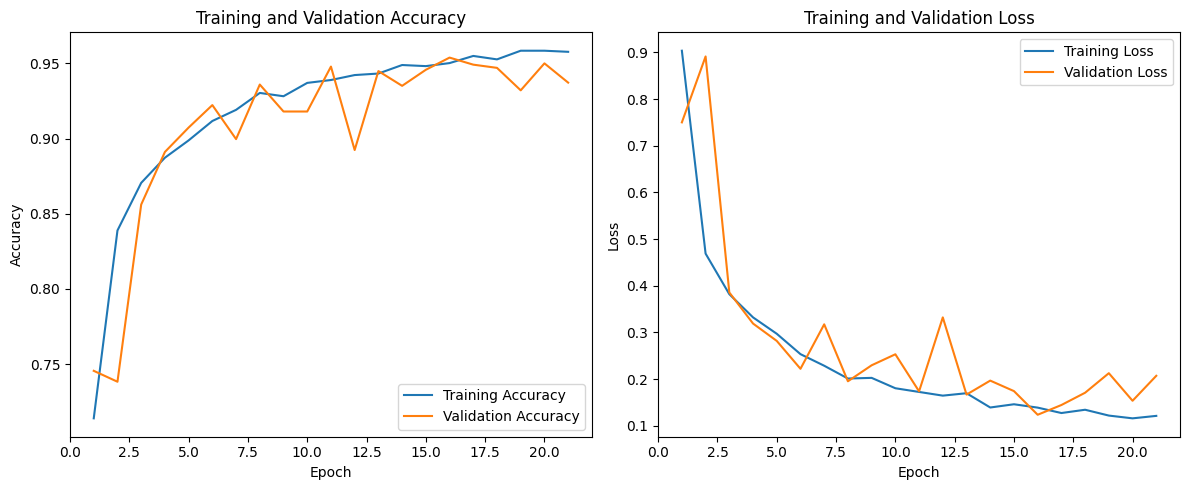

In [17]:
epochs_range = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [18]:
model.eval()

all_preds = []
all_labels = []
test_loss = 0.0
total_test_samples = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels) # Calculate loss on test set as well

        test_loss += loss.item() * inputs.size(0)
        total_test_samples += labels.size(0)

        # Get predictions
        _, preds = torch.max(outputs, 1) # Get the index of the max log-probability
        all_preds.extend(preds.cpu().numpy()) # Move predictions to CPU and store
        all_labels.extend(labels.cpu().numpy()) # Move labels to CPU and store

final_test_loss = test_loss / total_test_samples

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

final_test_accuracy = accuracy_score(all_labels, all_preds)

print(f"\nTest Loss: {final_test_loss:.4f}")
print(f"Test Accuracy: {final_test_accuracy:.4f}")

Testing:   0%|          | 0/74 [00:00<?, ?it/s]


Test Loss: 0.1345
Test Accuracy: 0.9569



Classification Report:
                                             precision    recall  f1-score   support

                        Tomato__Target_Spot       0.97      0.92      0.95       210
                Tomato__Tomato_mosaic_virus       0.85      0.98      0.91        56
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.99      0.98      0.98       481
                      Tomato_Bacterial_spot       0.96      0.98      0.97       319
                        Tomato_Early_blight       0.86      0.93      0.90       150
                         Tomato_Late_blight       0.98      0.88      0.93       287
                           Tomato_Leaf_Mold       0.99      0.93      0.96       143
                  Tomato_Septoria_leaf_spot       0.90      1.00      0.94       266
Tomato_Spider_mites_Two_spotted_spider_mite       0.97      0.97      0.97       252
                             Tomato_healthy       0.99      0.98      0.99       179

                                   accu

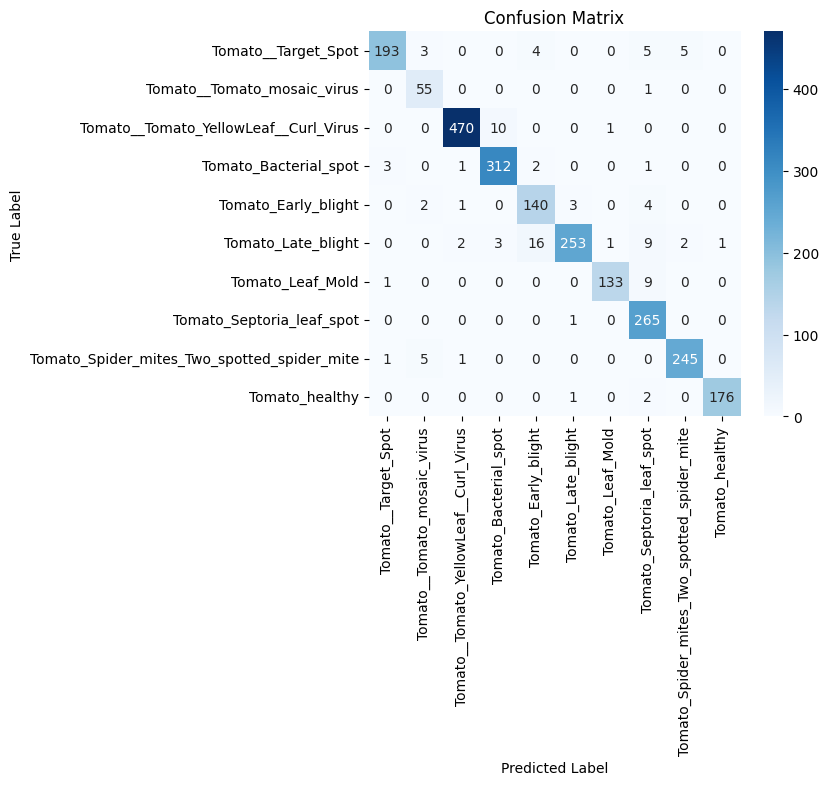

In [19]:
class_labels = [key for key, val in sorted(label_map_tomato.items(), key=lambda item: item[1])] # Sort by value (0, 1, 2)

print("\nClassification Report:")
# Ensure target_names are correct
print(classification_report(all_labels, all_preds, target_names=class_labels))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# Plotting Confusion Matrix (should work fine with multi-class cm)
plt.figure(figsize=(6, 5)) # Adjust size if needed for 3 classes
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()